In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

In [3]:
device = 'cuda'

In [4]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [5]:
def MARE_np(prediction, truth):
    epsilon = 1e-8  # Small value to prevent division by zero
    return np.sum((np.abs(prediction - truth)) / np.abs(truth + epsilon)) / len(truth)

In [6]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [7]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [8]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [9]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [10]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1


# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)


# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device='cuda') # (batch, output_dim)

In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2).to(device='cuda') # (batch, output_dim)

In [12]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3).to(device='cuda') # (batch, output_dim)

In [13]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4).to(device='cuda')  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4).to(device='cuda') # (batch, output_dim)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

In [15]:
normalized_test_1 = (first_piece[:] - first_piece.mean())/first_piece.std()
test_seq_1, test_labels_1 = create_sequences(normalized_test_1.values, 12)
test_tensor_seq_1 = torch.FloatTensor(test_seq_1).to(device=device)
test_tensor_labels_1 = torch.FloatTensor(test_labels_1).to(device=device)

In [16]:
normalized_test_2 = (second_piece[:] - second_piece.mean())/second_piece.std()
test_seq_2, test_labels_2 = create_sequences(normalized_test_2.values, 12)
test_tensor_seq_2 = torch.FloatTensor(test_seq_2).to(device=device)
test_tensor_labels_2 = torch.FloatTensor(test_labels_2).to(device=device)

In [17]:
normalized_test_3 = (third_piece[:] - third_piece.mean())/third_piece.std()
test_seq_3, test_labels_3 = create_sequences(normalized_test_3.values, 12)
test_tensor_seq_3 = torch.FloatTensor(test_seq_3).to(device='cuda')
test_tensor_labels_3 = torch.FloatTensor(test_labels_3).to(device='cuda')

In [18]:
normalized_test_4 = (fourth_piece[:] - fourth_piece.mean())/fourth_piece.std()
test_seq_4, test_labels_4 = create_sequences(normalized_test_4.values, 12)
test_tensor_seq_4 = torch.FloatTensor(test_seq_4).to(device='cuda')
test_tensor_labels_4 = torch.FloatTensor(test_labels_4).to(device='cuda')

In [19]:
test_labels_1_un = test_labels_1 * first_piece.std().values + first_piece.mean().values
test_labels_2_un = test_labels_2 * second_piece.std().values + second_piece.mean().values
test_labels_3_un = test_labels_3 * third_piece.std().values + third_piece.mean().values
test_labels_4_un = test_labels_4 * fourth_piece.std().values + fourth_piece.mean().values

In [20]:
def fed_avg(models):
    global_model = models[0]
    avg_state_dict = global_model.state_dict()
    
    with torch.no_grad():
        for key in avg_state_dict.keys():
            avg_state_dict[key] = torch.stack([m.state_dict()[key] for m in models], dim=0).mean(dim=0)
    
    global_model.load_state_dict(avg_state_dict)
    return global_model


In [21]:
def fed_avg_weighted(models, client_ds_sizes):
    global_model = models[0]
    avg_state_dict = global_model.state_dict()

    total_ds_size = sum(client_ds_sizes)
    weights = [size / total_ds_size for size in client_ds_sizes]

    with torch.no_grad():
        for key in avg_state_dict.keys():
            avg_state_dict[key] = torch.stack([models[i].state_dict()[key] * weights[i] for i in range(len(models))], dim=0).sum(dim=0)

    global_model.load_state_dict(avg_state_dict)
    return global_model

In [22]:
from torch.utils.data import DataLoader, TensorDataset

def get_client_data():
    client_data=[0]*4
    client_labels=[0]*4

    client_data[0] = train_seq_tensor1
    client_labels[0] = train_label_tensor1

    client_data[1] = train_seq_tensor2
    client_labels[1] = train_label_tensor2

    client_data[2] = train_seq_tensor3
    client_labels[2] = train_label_tensor3

    client_data[3] = train_seq_tensor4
    client_labels[3] = train_seq_tensor4

    return client_data, client_labels    

### Initialize clients and perform training

In [23]:
rounds = 10
local_epochs = 10

global_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
num_clients = 3

loss = torch.nn.SmoothL1Loss()
client_inputs, client_targets = get_client_data()

for round in range(rounds):
    print(f"\nFL Round {round+1}")
    local_models = []

    for i in range(num_clients):
        print(f"Client {i+1}")
        local_model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to(device)
        local_model.load_state_dict(global_model.state_dict())

        optimizer = optim.Adam(local_model.parameters(), lr=0.0001)
        local_model.train()

        for _ in range(local_epochs):
            inputs = client_inputs[i]
            targets = client_targets[i]
            for j in range(len(inputs)):
                optimizer.zero_grad()
                # forward pass
                y = local_model(inputs[j])
                error = loss(y, targets[j])
                # backward pass
                error.backward()
                optimizer.step()
        print(f"Client {i+1} Loss: {error.item()}")
        local_models.append(local_model)
    
    # aggregate
    global_model = fed_avg(local_models)


FL Round 1
Client 1
Client 1 Loss: 0.002776108216494322
Client 2
Client 2 Loss: 0.006799549795687199
Client 3
Client 3 Loss: 0.004829240497201681

FL Round 2
Client 1
Client 1 Loss: 0.003929262049496174
Client 2
Client 2 Loss: 0.0010028064716607332
Client 3
Client 3 Loss: 0.0048104082234203815

FL Round 3
Client 1
Client 1 Loss: 0.002300557214766741
Client 2
Client 2 Loss: 0.00023310510732699186
Client 3
Client 3 Loss: 0.019811058416962624

FL Round 4
Client 1
Client 1 Loss: 0.0015351619804278016
Client 2
Client 2 Loss: 8.486006845487282e-05
Client 3
Client 3 Loss: 0.025225555524230003

FL Round 5
Client 1
Client 1 Loss: 0.002091688336804509
Client 2
Client 2 Loss: 2.8621009562357358e-08
Client 3
Client 3 Loss: 0.027916407212615013

FL Round 6
Client 1
Client 1 Loss: 0.0026983071584254503
Client 2
Client 2 Loss: 7.465440830856096e-06
Client 3
Client 3 Loss: 0.026372097432613373

FL Round 7
Client 1
Client 1 Loss: 0.0032551418989896774
Client 2
Client 2 Loss: 7.151260069804266e-05
Clie

In [24]:
torch.save(global_model.state_dict(), 'fl_model123')

### Test on dataset 1

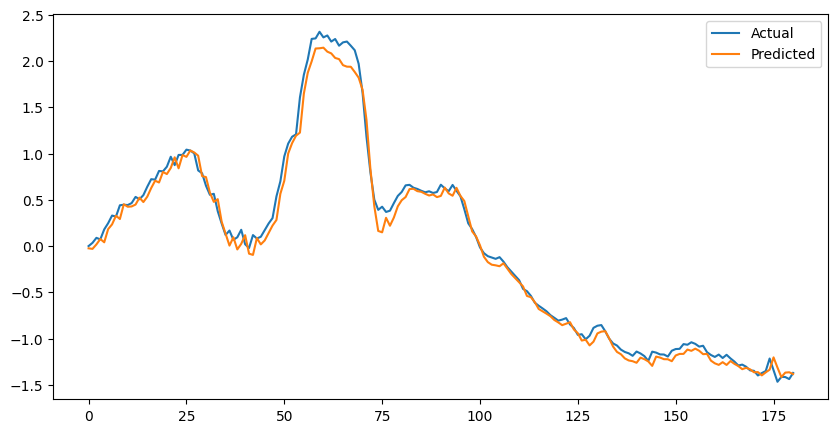

In [25]:
y_pred = []
global_model.eval()
with torch.no_grad():
    for i in range(len(test_tensor_seq_1)):
        pred = global_model(test_tensor_seq_1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [26]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * first_piece.std().values + first_piece.mean().values
print(f'MARE_np: {MARE_np(y_hat, test_labels_1_un)}')
loss(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_1.squeeze(1)).item()

MARE_np: 0.001890449951699644


0.005254685413092375

### Test on dataset 2

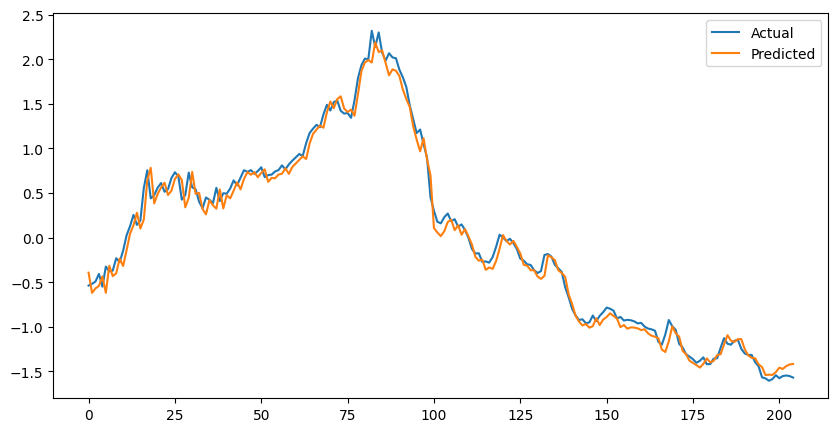

In [27]:
y_pred = []
global_model.eval()
with torch.no_grad():
    for i in range(len(test_tensor_seq_2)):
        pred = global_model(test_tensor_seq_2[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_2.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [28]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * second_piece.std().values + second_piece.mean().values
print(f'MARE_np: {MARE_np(y_hat, test_labels_2_un)}')
loss(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_2.squeeze(1)).item()

MARE_np: 0.002167217386582915


0.005926971323788166

### Test on dataset 3

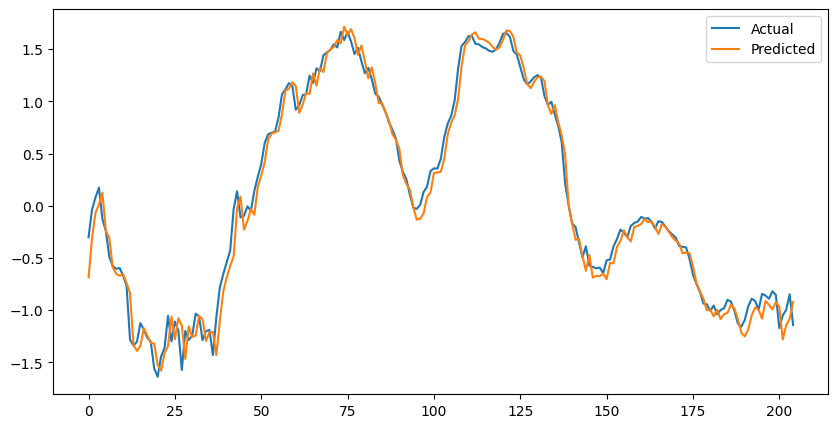

In [29]:
y_pred = []
global_model.eval()
with torch.no_grad():
    for i in range(len(test_tensor_seq_3)):
        pred = global_model(test_tensor_seq_3[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_3.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [30]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * third_piece.std().values + third_piece.mean().values
print(f'MARE_np: {MARE_np(y_hat, test_labels_3_un)}')
loss(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_3.squeeze(1)).item()

MARE_np: 0.0017505398694909265


0.009055609814822674

### Test on dataset 4

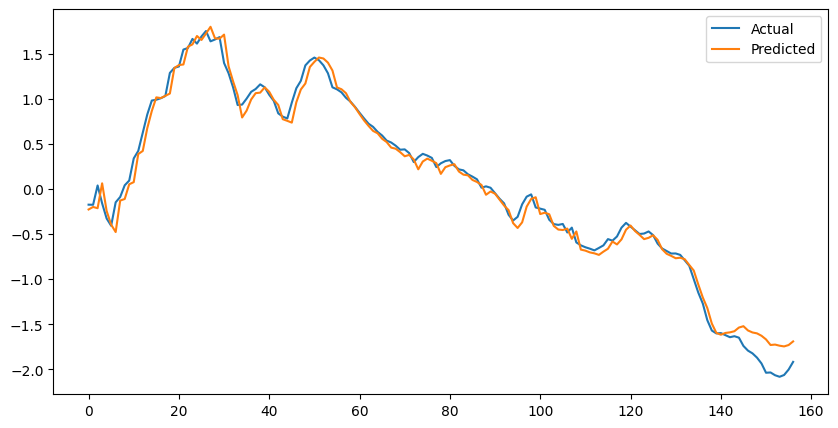

In [31]:
y_pred = []
global_model.eval()
with torch.no_grad():
    for i in range(len(test_tensor_seq_4)):
        pred = global_model(test_tensor_seq_4[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels_4.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [32]:
y_hat = torch.FloatTensor(y_pred).cpu().numpy().reshape(-1, 1) 
y_hat = y_hat * fourth_piece.std().values + fourth_piece.mean().values
print(f'MARE_np: {MARE_np(y_hat, test_labels_4_un)}')
loss(torch.FloatTensor(y_pred).to(device=device), test_tensor_labels_4.squeeze(1)).item()

MARE_np: 0.0020179485688057485


0.007263553328812122